In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.colors as mc 
from matplotlib.cm import ScalarMappable

pd.set_option("display.max_columns", None)

In [3]:
NY_boroughs = pd.read_html("https://www.citypopulation.de/en/usa/newyorkcity/")[0]

In [4]:
NY_boroughs.drop("Unnamed: 7", axis=1, inplace=True)

In [5]:
NY_boroughs["Area"] = [109.2, 179.7, 58.68, 281.6, 149.0, sum([109.2, 179.7, 58.68, 281.6, 149.0])]

In [6]:
NY_boroughs["Population_Density"] = NY_boroughs["Population Estimate 2022-07-01"] / NY_boroughs["Area"]

In [7]:
NY_boroughs["Name"] = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', "NEW YORK CITY"]

In [8]:
# If csv file is present - use csv file, otherwise
DF = pd.read_csv("../Data/Motor_Vehicle_Collisions_-_Crashes.csv", engine="c")

C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\3445798540.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  DF = pd.read_csv("../Data/Motor_Vehicle_Collisions_-_Crashes.csv", engine="c")


In [9]:
DF.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [10]:
def rename_headers(header: str) -> str:
    head = header.split(" ")
    for i in range(len(head)):
        head[i] = head[i].capitalize()

    return "_".join(head)


DF.rename(rename_headers, axis=1, inplace=True)

In [11]:
columns_to_check = [
    "Number_Of_Persons_Injured",
    "Number_Of_Persons_Killed",
    "Number_Of_Pedestrians_Injured",
    "Number_Of_Pedestrians_Killed",
    "Number_Of_Cyclist_Injured",
    "Number_Of_Cyclist_Killed",
    "Number_Of_Motorist_Injured",
    "Number_Of_Motorist_Killed",
]
DF = DF.dropna(subset=columns_to_check, how="any")

In [12]:
DF = DF.astype({"Number_Of_Persons_Injured": int, "Number_Of_Persons_Killed": int})

In [13]:
DF["Datetime"] = DF["Crash_Date"] + " " + DF["Crash_Time"]
DF["Datetime"] = pd.to_datetime(DF["Datetime"], format = "%m/%d/%Y %H:%M" )

In [15]:
DF.drop(columns=["Crash_Date", "Collision_id", "Crash_Time"], inplace=True)

In [57]:
# If csv file is not accessable, run this instead
# DF = pd.read_pickle("../Data/DataFramed.pkl", "bz2")

In [16]:
colours_boroughs = dict(
    zip(DF["Borough"].unique(), sns.color_palette("bright", 6).as_hex())
)

C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\2528802325.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=borough_df, x="Borough", y="count", palette=colours_boroughs)


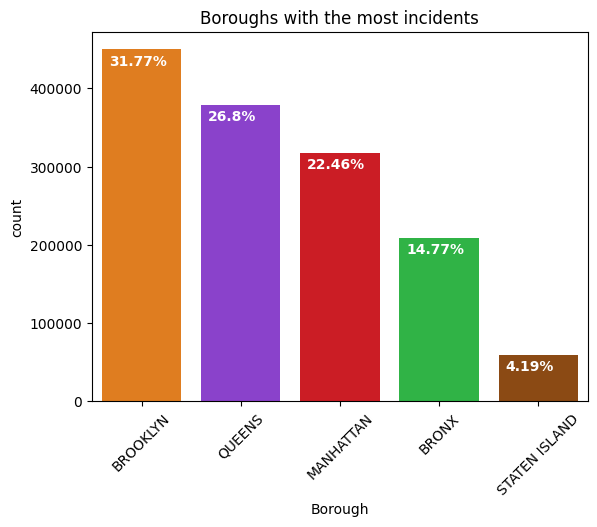

In [17]:
# Most crashed Borough:
borough_df = pd.DataFrame(
    DF["Borough"].value_counts()
).reset_index()  # .rename({"index": "Borough"})
ax = sns.barplot(data=borough_df, x="Borough", y="count", palette=colours_boroughs)
plt.title("Boroughs with the most incidents")
# https://www.kaggle.com/code/satyabrataroy/60-insights-extraction-us-accident-analysis
total = sum(borough_df["count"])
for i in ax.patches:
    ax.text(
        i.get_x() + 0.07,
        i.get_height() - 20000,
        str(round((i.get_height() / total) * 100, 2)) + "%",
        fontsize=10,
        weight="bold",
        color="white",
    )


plt.xticks(rotation=45)
plt.show()

In [18]:
DF["Year"] = DF["Datetime"].dt.year
DF["Month"] = DF["Datetime"].dt.month
DF["Day"] = DF["Datetime"].dt.day

In [19]:
DF_yearly = DF.groupby(["Borough", "Year", "Month"], as_index=False).agg(
    {
        "Number_Of_Persons_Injured": "sum",
        "Number_Of_Persons_Killed": "sum",
        "Number_Of_Pedestrians_Injured": "sum",
        "Number_Of_Pedestrians_Killed": "sum",
        "Number_Of_Cyclist_Injured": "sum",
        "Number_Of_Cyclist_Killed": "sum",
        "Number_Of_Motorist_Injured": "sum",
        "Number_Of_Motorist_Killed": "sum",
    }
)
DF_yearly["Number_Of_Incidents"] = DF_yearly[
    [
        "Number_Of_Persons_Injured",
        "Number_Of_Persons_Killed",
    ]
].sum(axis=1)

<AxesSubplot: xlabel='Year', ylabel='Number_Of_Incidents'>

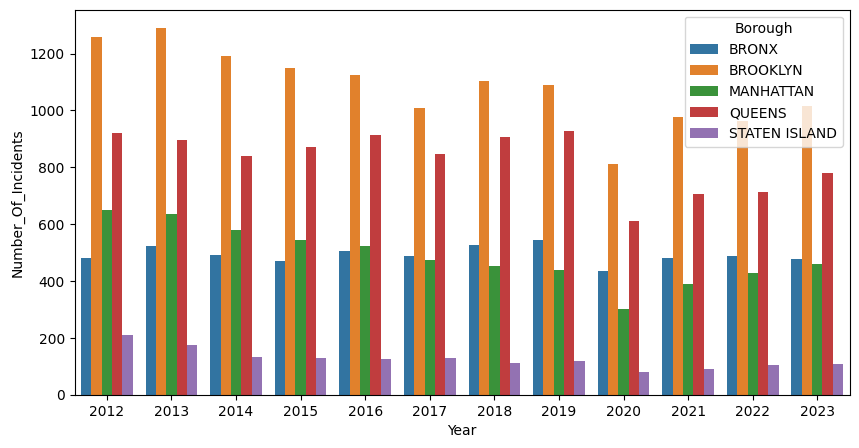

In [20]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = DF_yearly, x = "Year", y = "Number_Of_Incidents", errorbar=None, hue = "Borough")

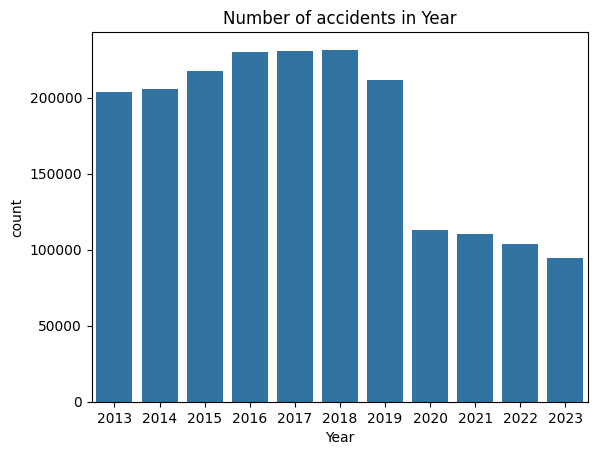

In [21]:
sns.countplot(x="Year",data=DF.query("Year != 2012"), orient="v")
plt.title("Number of accidents in Year")
plt.show()
# 2012 is not full
# what happened after 2019 and why didn't it come back to normal?
# started to work from home more oftet?

Text(0.5, 1.0, 'Number of incidents by borough over the years')

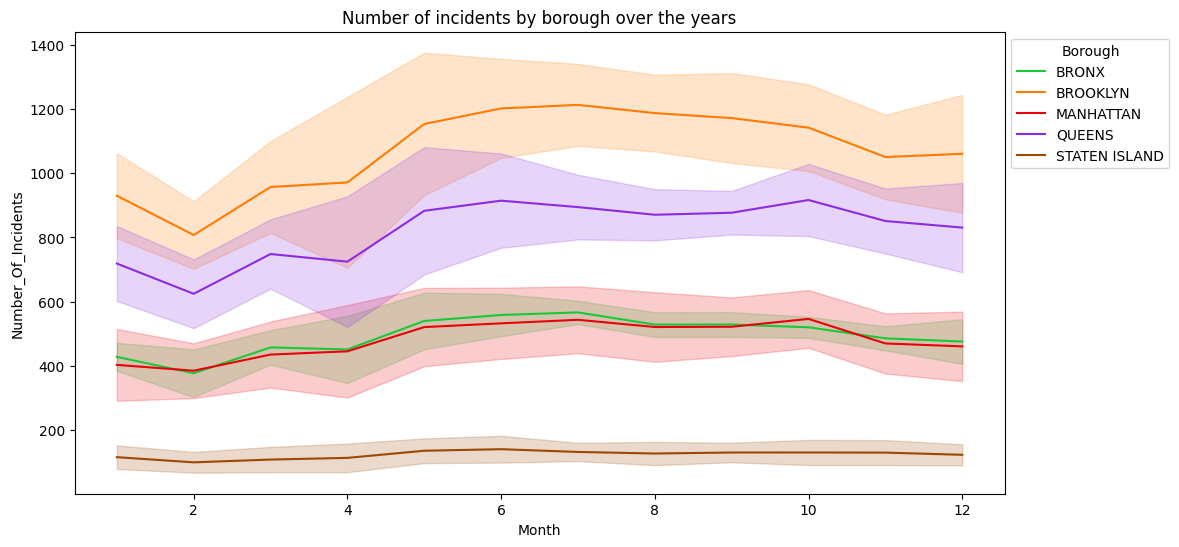

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=DF_yearly,
    x="Month",
    y="Number_Of_Incidents",
    hue="Borough",
    palette=colours_boroughs,
    ax=ax,
    errorbar=("sd", 1),
)  # standard deviation in staten island is the smallest -> the smallest area?
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Number of incidents by borough over the years")
# what happened in 2013?
# 2020 was covid -> less driving + less pedestrians

# follows the same-ish pattern, apart from Brooklyn, that started to decline

In [23]:
def DFconcat(DataFrame: pd.DataFrame, name: str):
    DataFrame["Mode"] = name
    DataFrame = (
        DataFrame.rename(
            {
                f"Number_Of_{name}_Injured": "Injured",
                f"Number_Of_{name}_Killed": "Killed",
            },
            axis=1,
        )
        .query("Injured > 0 | Killed > 0")
        .loc[
            :,
            [
                "Datetime",
                "Year",
                "Month",
                "Day",
                "Borough",
                "Latitude",
                "Longitude",
                "Injured",
                "Killed",
                "Mode",
            ],
        ]
    )
    return DataFrame.sort_values(by="Datetime")

In [24]:
DF_cycling = DFconcat(DF, "Cyclist")
DF_pedestrians = DFconcat(DF, "Pedestrians")
DF_motorist = DFconcat(DF, "Motorist")

In [25]:
DF_cycling_groupped = DF_cycling.groupby(["Year", "Month", "Day"], as_index=False).agg(
    {"Injured": "sum", "Killed": "sum"}
)
DF_pedestrians_groupped = DF_pedestrians.groupby(
    ["Year", "Month", "Day"], as_index=False
).agg({"Injured": "sum", "Killed": "sum"})
DF_motorist_groupped = DF_motorist.groupby(
    ["Year", "Month", "Day"], as_index=False
).agg({"Injured": "sum", "Killed": "sum"})

In [26]:
DF_factors = DF[
    [
        "Datetime",
        "Borough",
        "Contributing_Factor_Vehicle_1",
        "Contributing_Factor_Vehicle_2",
        "Contributing_Factor_Vehicle_3",
        "Contributing_Factor_Vehicle_4",
        "Contributing_Factor_Vehicle_5",
    ]
].map(lambda s: s.lower() if type(s) == str else s)
DF_factors.replace("unspecified", np.NaN, inplace=True)

In [27]:
DF_vehicle = DF[
    [
        "Datetime",
        "Borough",
        "Vehicle_Type_Code_1",
        "Vehicle_Type_Code_2",
        "Vehicle_Type_Code_3",
        "Vehicle_Type_Code_4",
        "Vehicle_Type_Code_5",
    ]
].map(lambda s: s.lower() if type(s) == str else s)
DF_vehicle.replace("unspecified", np.NaN, inplace=True)

Text(0.5, 1.0, 'Top 10 most occuring vehicle types in a crash')

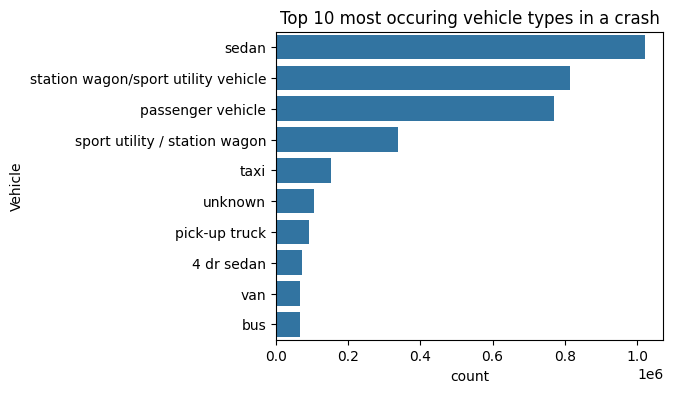

In [28]:
plt.subplots(figsize=(5, 4))
vehicles = DF_vehicle.iloc[:, 2:].stack().value_counts()
sns.barplot(
    data=vehicles
    .reset_index()
    .rename({"index": "Vehicle"}, axis=1)
    .head(10),
    y="Vehicle",
    x="count",
)
plt.title("Top 10 most occuring vehicle types in a crash")

Text(0.5, 1.0, 'Top 10 most contributing factors in a crash')

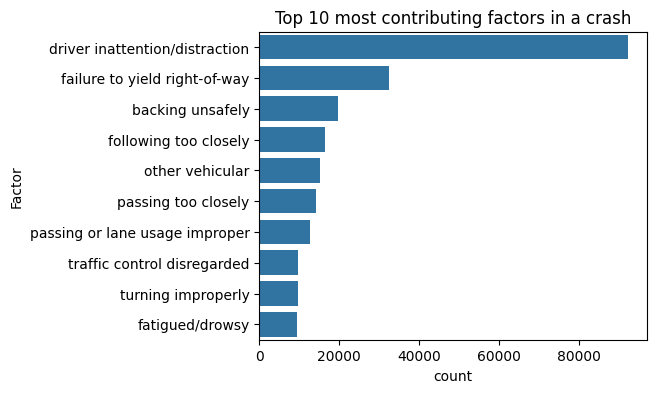

In [29]:
plt.subplots(figsize=(5, 4))
contributing_factors = pd.concat(
    [DF_factors.query("Borough == 'brooklyn'")[col] for col in DF_factors.query("Borough == 'brooklyn'").columns[2:]], ignore_index=True
)
sns.barplot(
    data=pd.DataFrame(contributing_factors.dropna().value_counts())
    .reset_index()
    .rename({"index": "Factor"}, axis=1)
    .head(10),
    y="Factor",
    x="count",
)

plt.title("Top 10 most contributing factors in a crash")

Text(0.5, 1.0, 'Top 10 most contributing factors in a crash')

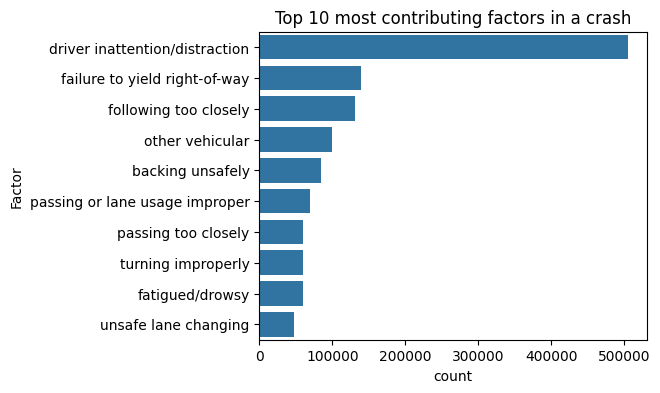

In [30]:
plt.subplots(figsize=(5, 4))
contributing_factors = pd.concat(
    [DF_factors[col] for col in DF_factors.columns[2:]], ignore_index=True
)
sns.barplot(
    data=pd.DataFrame(contributing_factors.dropna().value_counts())
    .reset_index()
    .rename({"index": "Factor"}, axis=1)
    .head(10),
    y="Factor",
    x="count",
)

plt.title("Top 10 most contributing factors in a crash")

In [31]:
DF_groupped = (
    pd.concat([DF_cycling, DF_pedestrians, DF_motorist], ignore_index=True)

    .sort_values(by="Datetime")
    .dropna(subset=["Borough", "Latitude", "Longitude"])
)
DF_groupped["casualties"] = DF_groupped["Injured"] + DF_groupped["Killed"]
DF_groupped["Hour"] = DF_groupped["Datetime"].dt.hour
DF_groupped['Weekday'] = DF_groupped['Datetime'].dt.weekday
# Only where incidents had injuries

In [32]:
map_center = [DF_groupped["Latitude"].iloc[0], DF_groupped["Longitude"].iloc[0]]
heatmap_map = folium.Map(location=map_center, zoom_start=10)

# Create a HeatMap layer
heat_data = [
    [row["Latitude"], row["Longitude"]] for index, row in DF_groupped.iterrows()
]
HeatMap(heat_data, radius=2, blur=1, width=700, height = 1000 ).add_to(
    heatmap_map,
)

In [33]:
heatmap_map
# identify the busiest areas and why crashes happen there
# why so little in staten island?

<AxesSubplot: xlabel='Month', ylabel='count'>

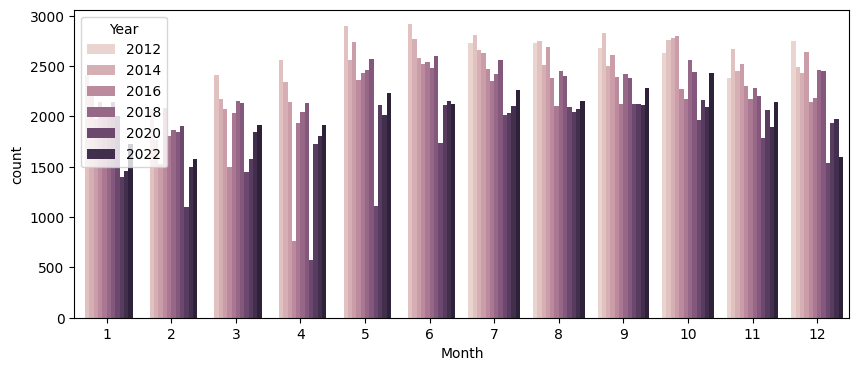

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=DF_groupped, x="Month", hue="Year")

In [35]:
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'January'),
  Text(1.5, 0, 'February'),
  Text(2.5, 0, 'March'),
  Text(3.5, 0, 'April'),
  Text(4.5, 0, 'May'),
  Text(5.5, 0, 'June'),
  Text(6.5, 0, 'July'),
  Text(7.5, 0, 'August'),
  Text(8.5, 0, 'September'),
  Text(9.5, 0, 'October'),
  Text(10.5, 0, 'November'),
  Text(11.5, 0, 'December')])

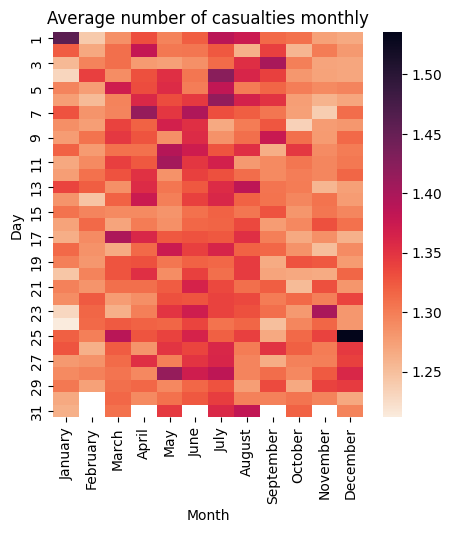

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
df2 = DF_groupped.query("Year > 2012").reset_index().pivot_table(
    columns="Month", index="Day", values="casualties", aggfunc="mean"
)
sns.heatmap(df2, cmap="rocket_r")
plt.title("Average number of casualties monthly")
ax.set_xticklabels(month_dict.values())
# ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xticks(rotation = 90)


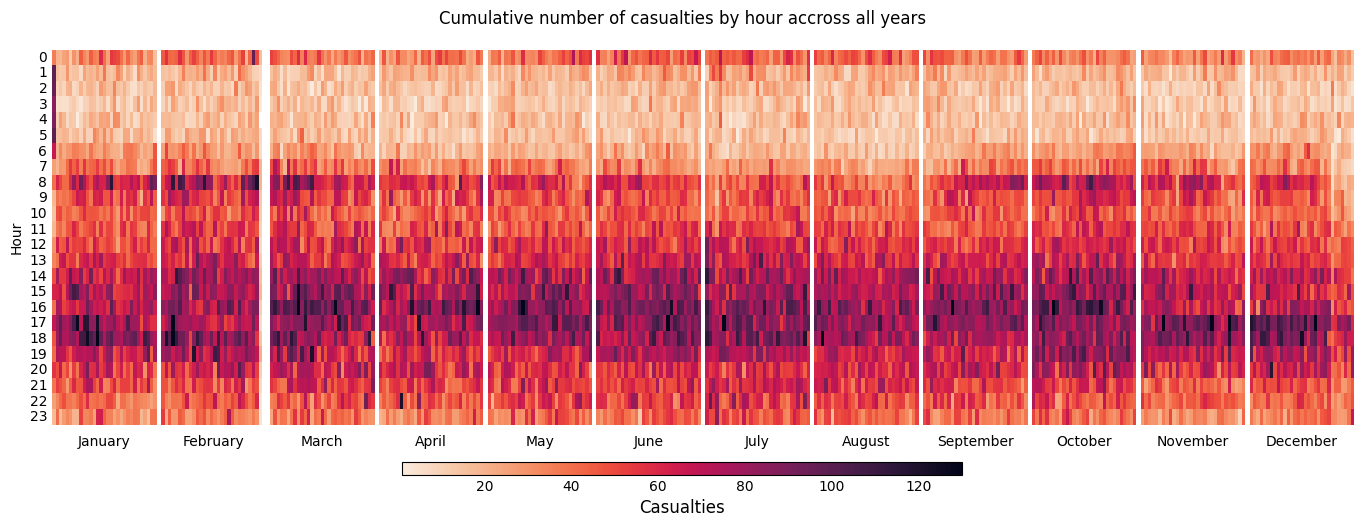

In [37]:
fig, axes = plt.subplots(1, 12, figsize=(14, 5), sharey=True)
for index, month in enumerate(sorted(DF_groupped["Month"].unique())):
    data = DF_groupped.query("Month == @month")
    df3 = data.reset_index().pivot_table(
        columns="Day", index="Hour", values="casualties", aggfunc="sum"
    )
    pl = sns.heatmap(df3, cmap="rocket_r", ax=axes[index], cbar=False)
    axes[index].yaxis.set_tick_params(length=0)
    axes[index].xaxis.set_tick_params(length=0)
    if index > 0:
        axes[index].set_ylabel("")
    pl.set_xlabel(month_dict[month])
    axes[index].set_xticks([10,20,30])

fig.suptitle("Cumulative number of casualties by hour accross all years")
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, bottom=0.15, wspace=0.04)

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.025])

norm = mc.Normalize(1, 130)

cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap="rocket_r"),
    cax=cbar_ax,  # Pass the new axis
    orientation="horizontal",
)

cb.ax.xaxis.set_tick_params(size=0)

cb.set_label("Casualties", size=12)
# https://python-graph-gallery.com/heatmap-for-timeseries-matplotlib/

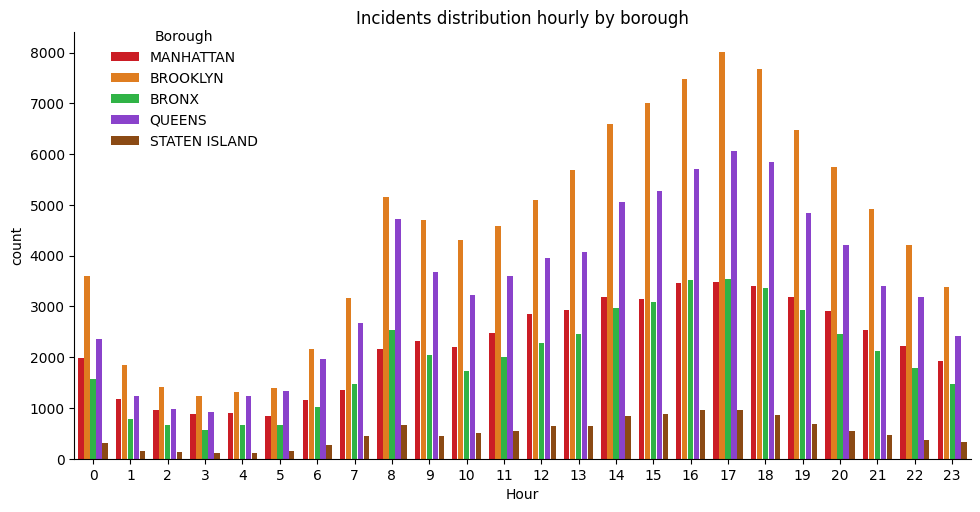

In [38]:

g = sns.catplot(
    data=DF_groupped,
    x="Hour",
    hue="Borough",
    palette=colours_boroughs,
    kind="count",
    estimator="sum",
    aspect=2,
    gap = 0.1
)
plt.title("Incidents distribution hourly by borough")


sns.move_legend(g ,loc='upper left', bbox_to_anchor=(0.1,1) )
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))


Text(0.5, 1.0, 'Number of incidents split by years')

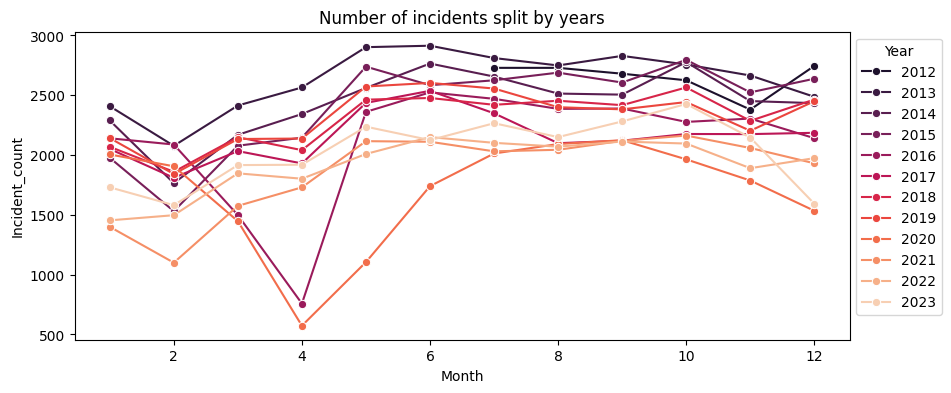

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
data = (
    DF_groupped.groupby(["Year", "Month"], as_index=False)
    .agg({"Injured": "sum", "Killed": "sum", "Day": "count"})
    .rename({"Day": "Incident_count"}, axis=1)
)
data["Year"] = data["Year"].astype("string")
sns.lineplot(
    data=data.query("Year != 2012"),
    x="Month",
    y="Incident_count",
    hue="Year",
    marker="o",
    palette="rocket",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Number of incidents split by years")

<AxesSubplot: xlabel='Month', ylabel='count'>

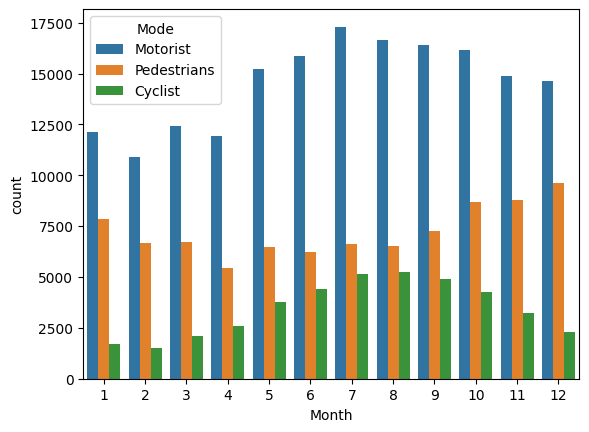

In [40]:
sns.countplot(data=DF_groupped, x="Month", hue="Mode", )
# temperature affects, as negative correlation between pedestians and cyclists starting from May, when the temperature goes up.

<AxesSubplot: xlabel='Hour', ylabel='Density'>

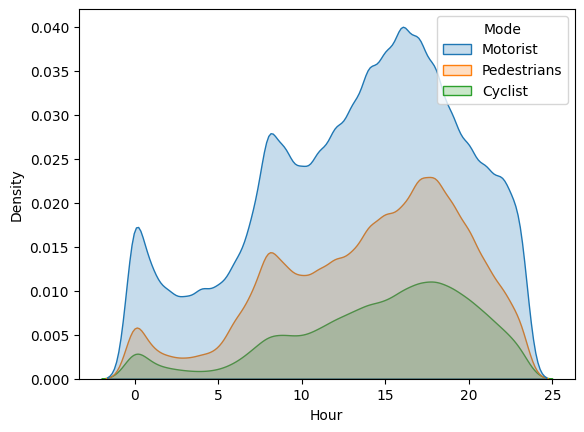

In [41]:
sns.kdeplot(data=DF_groupped, x="Hour", hue="Mode", multiple="layer", fill = True)

C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\383456308.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  c = sns.countplot(x="Weekday", data=DF_groupped, orient = 'v', palette = "crest_r")
C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\383456308.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])


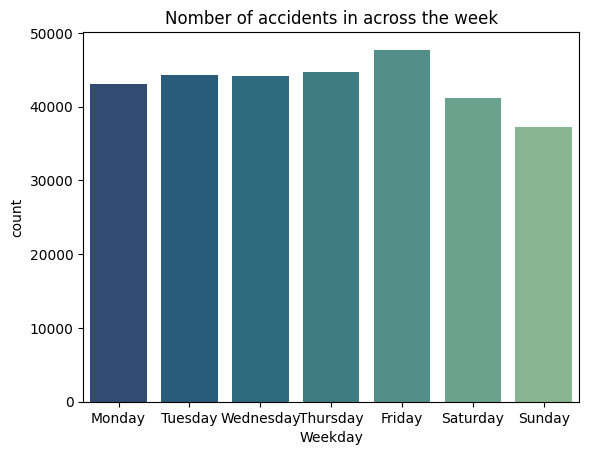

In [42]:
fig, ax = plt.subplots()
c = sns.countplot(x="Weekday", data=DF_groupped, orient = 'v', palette = "crest_r")
c.set_title("Nomber of accidents in across the week")
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

In [43]:
Weekday = DF_groupped.query("Weekday < 5")
Weekend = DF_groupped.query("Weekday >= 5")

Text(0.5, 0.98, 'Incidents by hour on weekends and weekdays')

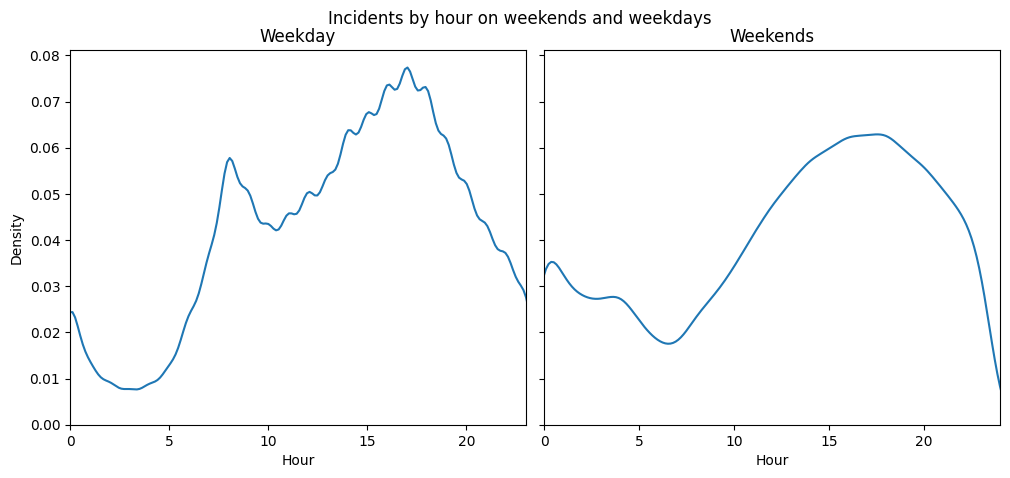

In [44]:
fig, axes = plt.subplots(1,2, figsize = (10,5), sharey= True)
# sns.barplot(data = Weekday["Hour"].value_counts().reset_index().rename({"index": "Hour"}))
sns.kdeplot(x="Hour", data=Weekday, ax = axes[0]).set(title = "Weekday", xlim = (0,23))
sns.kdeplot(x="Hour", data=Weekend, ax = axes[1]).set(title = "Weekends", xlim = (0,24))
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, bottom=0.15, wspace=0.04)
plt.suptitle("Incidents by hour on weekends and weekdays")

In [45]:
# who crashes into who more -> what condition hits the most pedestrians vs motorists?

In [46]:
# https://www.kaggle.com/code/anoopjohny/car-crashes-analysis 
# similar dataset analysis

In [47]:
for b in DF_groupped["Borough"].unique():
    df = DF_groupped.query("Borough == @b")
    df_groupped = df.groupby("Borough").agg(len)

In [48]:
number_of_incidents = DF_groupped.groupby("Borough").agg(len)["Datetime"].reset_index().rename({"Datetime":"Incidents"}, axis=1)

In [49]:
DF_incidents_borough = number_of_incidents.join(NY_boroughs[["Name", "Population Estimate 2022-07-01", "Area", "Population_Density"]])

In [50]:
DF_incidents_borough
#https://www.citypopulation.de/en/usa/newyorkcity/

Borough  Incidents           Name  Population Estimate 2022-07-01  \
0          BRONX      47653          BRONX                         1379946   
1       BROOKLYN     107115       BROOKLYN                         2590516   
2      MANHATTAN      53637      MANHATTAN                         1596273   
3         QUEENS      82020         QUEENS                         2278029   
4  STATEN ISLAND      12015  STATEN ISLAND                          491133   

     Area  Population_Density  
0  109.20        12636.868132  
1  179.70        14415.781859  
2   58.68        27203.016360  
3  281.60         8089.591619  
4  149.00         3296.194631

In [51]:
DF_incidents_borough["IncidentsPerArea"] = DF_incidents_borough["Incidents"] / DF_incidents_borough["Area"]
DF_incidents_borough["IncedentPerPerson"] = DF_incidents_borough["Incidents"] / DF_incidents_borough["Population Estimate 2022-07-01"]
DF_incidents_borough["IncedentPerDensity"] = DF_incidents_borough["Incidents"] / DF_incidents_borough["Population_Density"]

C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\2807419501.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = DF_incidents_borough, x = "Borough", y = "IncidentsPerArea", palette=colours_boroughs)


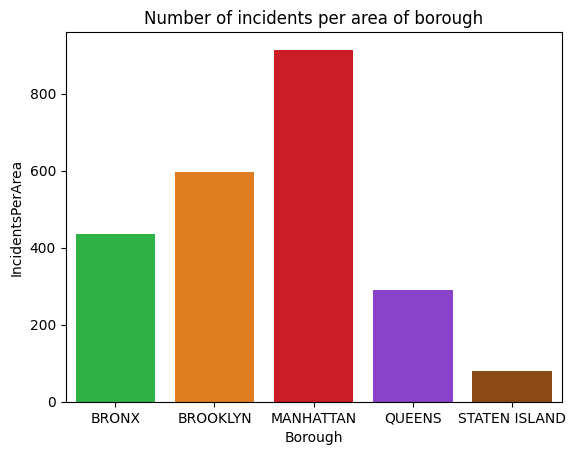

In [52]:
sns.barplot(data = DF_incidents_borough, x = "Borough", y = "IncidentsPerArea", palette=colours_boroughs)
plt.title("Number of incidents per area of borough")
plt.show()

C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\64551576.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = DF_incidents_borough, x = "Borough", y = "IncedentPerPerson", palette=colours_boroughs)


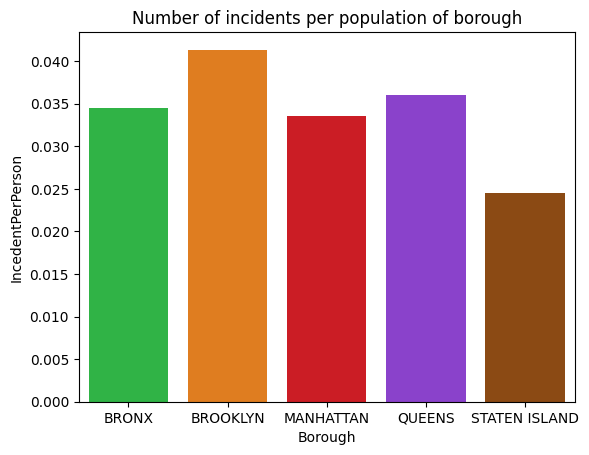

In [53]:
sns.barplot(data = DF_incidents_borough, x = "Borough", y = "IncedentPerPerson", palette=colours_boroughs)
plt.title("Number of incidents per population of borough")
plt.show()

C:\Users\dima1\AppData\Local\Temp\ipykernel_13100\4196371224.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = DF_incidents_borough, x = "Borough", y = "IncedentPerDensity", palette=colours_boroughs)


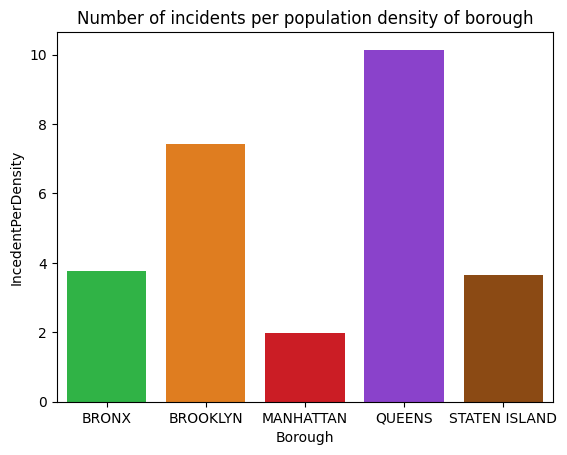

In [54]:
sns.barplot(data = DF_incidents_borough, x = "Borough", y = "IncedentPerDensity", palette=colours_boroughs)
plt.title("Number of incidents per population density of borough")
plt.show()

Text(0.5, 1.0, 'Mode of transport involved by borough')

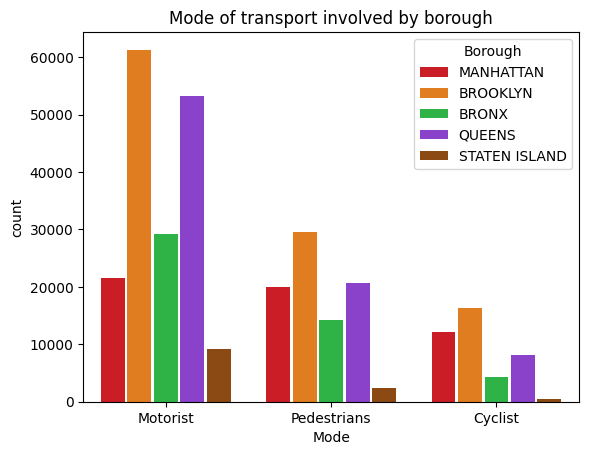

In [55]:
sns.countplot(data = DF_groupped, x = "Mode", hue = "Borough", palette=colours_boroughs, gap=0.1)
plt.title("Mode of transport involved by borough")